<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2024/blob/main/IMT_regressao_robust_solucao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="ITM">
</head>

<img src="https://maua.br/images/selo-60-anos-maua.svg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **Aprendizado Supervisionado: Regressão Linear Robusta `scikit-learn`**

Neste laboratório:

1. Termos de Interação
2. Scikit-learn
3. Outliers e modelos Robustos
4. Resíduos*
5. Homocedasticidade de Log*
6. Variáveis preditoras categóricas*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Métricas de Erro

Veja [A Comprehensive Overview of Regression Evaluation Metrics](https://developer.nvidia.com/blog/a-comprehensive-overview-of-regression-evaluation-metrics/) e [Metrics and scoring: quantifying the quality of predictions](
https://scikit-learn.org/stable/modules/model_evaluation.html)

In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    metrics = {}

    # Mean Squared Error (MSE)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Mean Absolute Percentage Error (MAPE)
    if np.any(y_true == 0):
        metrics['MAPE'] = 'Undefined (division by zero)'
    else:
        metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Mean Absolute Error (MAE)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)

    # Symmetric Mean Absolute Percentage Error (sMAPE)
    metrics['sMAPE'] = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    # Mean Absolute Deviation (MAD)
    metrics['MAD'] = np.mean(np.abs(y_true - np.mean(y_true)))

    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

    return metrics

# calculate_metrics(y_true, y_pred)


# Caso: **Estimando o preço de imóveis**

Empregue modelos de regressão simples e múltipla para estimar o preço dos imóveis.


In [3]:
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/data_load/regressao_preco_imoveis.xlsx')
df = df.drop(columns='bairro')
df.head()

,areaM2,suites,dormitorios,banheiros,vagas,preco
0,32,1,1,1,1,490000
1,157,2,2,2,2,3180000
2,205,2,3,3,3,1900000
3,193,3,3,3,3,3565000
4,116,1,3,2,2,1605000


In [4]:
df_case = pd.DataFrame({'areaM2':[134], 'suites':[1], 'dormitorios':[4], 'vagas':[2]})
df_case


,areaM2,suites,dormitorios,vagas
0,134,1,4,2


# `Statsmodels`

In [5]:
lm = sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas', data=df)
# lm = sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas - 1', data=df)
lm = lm.fit()
print(lm.summary())
print()

calculate_metrics(df.preco, lm.predict(df.drop(columns='preco')))
print()

preco = lm.predict(df_case)
print()
print(f'Preço estimado: {preco[0]:.2f}')

                            OLS Regression Results                            
Dep. Variable:                  preco   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     2027.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:09:57   Log-Likelihood:                -55099.
No. Observations:                3741   AIC:                         1.102e+05
Df Residuals:                    3736   BIC:                         1.102e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3407.3121   4.04e+04     -0.084      

# `Scikit-learn`

In [6]:
X = df[['areaM2', 'suites', 'dormitorios', 'vagas']]
y = df['preco']

model = LinearRegression(fit_intercept=False) # set fit_intercept to False
# model = LinearRegression()
model.fit(X, y)

print("Coeficientes: ", dict(zip(model.feature_names_in_, model.coef_)))
print("Intercept: ", model.intercept_)
print("Score (R2): ", model.score(X, y)) # R2
print()

calculate_metrics(df.preco, lm.predict(df.drop(columns='preco')))
print()

# Predição
y_pred = model.predict(df_case)
print(f'Preço estimado (scikit-learn): {y_pred[0]:.2f}')

Coeficientes:  {'areaM2': 10471.23486790231, 'suites': 202913.06609277183, 'dormitorios': -312438.48835904873, 'vagas': 296481.8403449148}
Intercept:  0.0
Score (R2):  0.6845683088812347

MSE: 363479068155.80
RMSE: 602892.25
MAPE: 27.16
MAE: 398507.18
sMAPE: 24.81
MAD: 773278.64

Preço estimado (scikit-learn): 949268.27


# Q1. Heterocedasticidade e Log

Faça o modelo de regressão anterior considerando apenas coeficientes significativos e o log dos valores (tanto da variável preditora como da variável alvo).

Faça a predição do novo caso com o novo modelo.

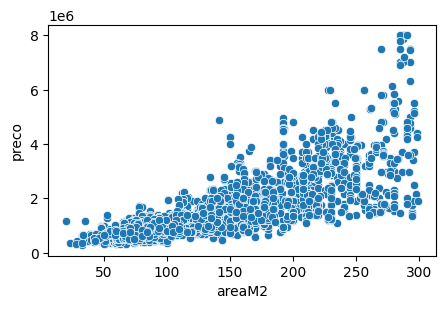

In [7]:
plt.figure(figsize=(5,3))

sns.scatterplot(x=df.areaM2, y=df.preco)
plt.show()


In [8]:
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/data_load/regressao_preco_imoveis.xlsx')
df = df.drop(columns='bairro')
df.head()

,areaM2,suites,dormitorios,banheiros,vagas,preco
0,32,1,1,1,1,490000
1,157,2,2,2,2,3180000
2,205,2,3,3,3,1900000
3,193,3,3,3,3,3565000
4,116,1,3,2,2,1605000


In [9]:
# lm = sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas - 1', data=df)
lm = sm.ols(formula='np.log(preco) ~ np.log(areaM2) + np.log(suites) + np.log(dormitorios) + np.log(vagas) - 1', data=df)
lm = lm.fit()
print(lm.summary())
print()

calculate_metrics(np.log(df.preco), lm.predict(df.drop(columns='preco')))
print()

preco = lm.predict(df_case) # note que o statsmodels faz as transformações informadas de forma AUTOMÁTICA das variáveis (veja abaixo)
print()
print(f'Preço estimado: {np.exp(preco[0]):.2f}') # mas ele não reverte a saída

                                 OLS Regression Results                                
Dep. Variable:          np.log(preco)   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          3.502e+05
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:10:05   Log-Likelihood:                         -4114.0
No. Observations:                3741   AIC:                                      8236.
Df Residuals:                    3737   BIC:                                      8261.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

### Veja como funcionam as transformações do `statsmodels`

In [10]:
df = pd.DataFrame()
df['X'] = np.arange(0,100)
df['y'] = 2*df['X'] + 1 + np.random.sample(100)

lm = sm.ols(formula='y ~ X', data=df).fit()
print(lm.summary())
print()

print(np.round(lm.predict()))



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.785e+06
Date:                Thu, 22 Aug 2024   Prob (F-statistic):          1.40e-226
Time:                        18:10:06   Log-Likelihood:                -19.469
No. Observations:                 100   AIC:                             42.94
Df Residuals:                      98   BIC:                             48.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4549      0.059     24.680      0.0

In [11]:
df = pd.DataFrame()
df['X'] = np.arange(0,100)
df['y'] = 2*df['X'] + 1 + np.random.sample(100)

lm = sm.ols(formula='np.log1p(y) ~ np.log1p(X)', data=df).fit()
print(lm.summary())
print()

print(np.round(np.exp(lm.predict())))
print(np.round(np.exp(lm.predict(df['X'])).values))


                            OLS Regression Results                            
Dep. Variable:            np.log1p(y)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.532e+05
Date:                Thu, 22 Aug 2024   Prob (F-statistic):          2.39e-158
Time:                        18:10:06   Log-Likelihood:                 236.12
No. Observations:                 100   AIC:                            -468.2
Df Residuals:                      98   BIC:                            -463.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.7882      0.009     84.139      

### Com o `scikit-learn`

In [12]:
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/data_load/regressao_preco_imoveis.xlsx')
df = df.drop(columns='bairro')
df = np.log(df)
df.head()

,areaM2,suites,dormitorios,banheiros,vagas,preco
0,3.465736,0.000000,0.000000,0.000000,0.000000,13.102161
1,5.056246,0.693147,0.693147,0.693147,0.693147,14.972392
2,5.323010,0.693147,1.098612,1.098612,1.098612,14.457364
3,5.262690,1.098612,1.098612,1.098612,1.098612,15.086675
4,4.753590,0.000000,1.098612,0.693147,0.693147,14.288634


In [13]:
X = df[['areaM2', 'suites', 'dormitorios', 'vagas']]
y = df['preco']

model = LinearRegression(fit_intercept=False) # set fit_intercept to False
# model = LinearRegression()
model.fit(X, y)

print("Coeficientes: ", dict(zip(model.feature_names_in_, model.coef_)))
print("Intercept: ", model.intercept_)
print("Score (R2): ", model.score(X, y)) # R2
print()

# calculate_metrics(df.preco, lm.predict(df.drop(columns='preco')))
# print()

# Predição
y_pred = model.predict(np.log(df_case))
print(f'Preço estimado (scikit-learn): {np.exp(y_pred[0]):.2f}')


Coeficientes:  {'areaM2': 3.2946860200052823, 'suites': -0.46343682756966564, 'dormitorios': -1.5903518226562143, 'vagas': -0.16344293354886352}
Intercept:  0.0
Score (R2):  -0.592856602827865

Preço estimado (scikit-learn): 1003353.60


# Q2. Termos de interação

Volte a considerar os valores normais, sem aplicação do log. Crie modelos de normalização considerando as interações:

* dormitorios+vagas
* dormitorios+suites
* dormitorios+suites e areaM2+vagas

Considerando somente coeficientes significativos.

Qual o R2 e a predição do melhor modelo para o novo caso?

In [14]:
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/data_load/regressao_preco_imoveis.xlsx')
df = df.drop(columns='bairro')
df.head()

,areaM2,suites,dormitorios,banheiros,vagas,preco
0,32,1,1,1,1,490000
1,157,2,2,2,2,3180000
2,205,2,3,3,3,1900000
3,193,3,3,3,3,3565000
4,116,1,3,2,2,1605000


In [15]:
lms = [sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas +  dormitorios:vagas - 1', data=df),
       sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas +  dormitorios:suites - 1', data=df),
       sm.ols(formula='preco ~ areaM2 + suites + dormitorios + vagas +  dormitorios:suites + areaM2:vagas - 1', data=df),
       sm.ols(formula='preco ~ areaM2 + suites + vagas + dormitorios:suites + areaM2:vagas - 1', data=df)]

for lm in lms:
  lm = lm.fit()
  print(lm.summary())
  print()

  # calculate_metrics(df.preco, lm.predict(df.drop(columns='preco')))
  # print()

  preco = lm.predict(df_case)
  print(lm.rsquared)
  print()
  print(f'Preço estimado: {preco[0]:.2f}')
  print()

                                 OLS Regression Results                                
Dep. Variable:                  preco   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              6589.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                        0.00
Time:                        18:10:17   Log-Likelihood:                         -55098.
No. Observations:                3741   AIC:                                  1.102e+05
Df Residuals:                    3736   BIC:                                  1.102e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

# Q3. Termos de Interação com o scikit-learn

Reconstrua o melhor modelo do exercício anterior com o scikit-learn.

In [16]:
df = pd.read_excel('http://meusite.mackenzie.br/rogerio/data_load/regressao_preco_imoveis.xlsx')
df = df.drop(columns='bairro')
df.head()

,areaM2,suites,dormitorios,banheiros,vagas,preco
0,32,1,1,1,1,490000
1,157,2,2,2,2,3180000
2,205,2,3,3,3,1900000
3,193,3,3,3,3,3565000
4,116,1,3,2,2,1605000


In [17]:
df['dormitorios:suites'] = df['dormitorios'] * df['suites']
df['areaM2:vagas'] = df['areaM2'] * df['vagas']

df_case['dormitorios:suites'] = df_case['dormitorios'] * df_case['suites']
df_case['areaM2:vagas'] = df_case['areaM2'] * df_case['vagas']

display(df.head())
display(df_case)

,areaM2,suites,dormitorios,banheiros,vagas,preco,dormitorios:suites,areaM2:vagas
0,32,1,1,1,1,490000,1,32
1,157,2,2,2,2,3180000,4,314
2,205,2,3,3,3,1900000,6,615
3,193,3,3,3,3,3565000,9,579
4,116,1,3,2,2,1605000,3,232


,areaM2,suites,dormitorios,vagas,dormitorios:suites,areaM2:vagas
0,134,1,4,2,4,268


In [18]:
X = df.drop(columns=['preco','banheiros','dormitorios'])
y = df['preco']

model = LinearRegression(fit_intercept=False) # set fit_intercept to False
model.fit(X, y)

print("Coeficientes: ", model.feature_names_in_)
print("Coeficientes: ", dict(zip(model.feature_names_in_, model.coef_)))
print("Intercept: ", model.intercept_)
print("Score (R2): ", model.score(X, y)) # R2
print()

# from sklearn.metrics import r2_score
# print("Score (R2)B: ", r2_score(y, model.predict(df.drop(columns=['preco','banheiros','dormitorios']))))

calculate_metrics(df.preco, model.predict(df.drop(columns=['preco','banheiros','dormitorios'])))
print()

# Predição
y_pred = model.predict(df_case.drop(columns='dormitorios'))
print(f'Preço estimado (scikit-learn): {y_pred[0]:.2f}')

Coeficientes:  ['areaM2' 'suites' 'vagas' 'dormitorios:suites' 'areaM2:vagas']
Coeficientes:  {'areaM2': 3588.4399521448354, 'suites': 606383.2763916976, 'vagas': -91523.06646181596, 'dormitorios:suites': -129541.37263719193, 'areaM2:vagas': 2563.087340982631}
Intercept:  0.0
Score (R2):  0.7034378664247192

MSE: 341735899922.54
RMSE: 584581.82
MAPE: 25.25
MAE: 380329.39
sMAPE: 23.00
MAD: 773278.64

Preço estimado (scikit-learn): 1072930.01


In [19]:
print("Score (R2)B: ", r2_score(y, lm.predict(df.drop(columns='preco'))))

Score (R2)B:  0.7034378664247192


# Q4. Modelos robustos

Aplique algum dos modelos robustos de regressão linear do scikit-learn empregando os mesmos preditores do exercício 1.

In [20]:
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                                  RANSACRegressor, TheilSenRegressor)

X = df.drop(columns=['preco','banheiros','dormitorios'])
y = df['preco']

model = HuberRegressor(max_iter=1000, fit_intercept=False)
model.fit(X, y)

print("Coeficientes: ", dict(zip(model.feature_names_in_, model.coef_)))
print("Intercept: ", model.intercept_)
print("Score (R2): ", model.score(X, y)) # R2
print()

calculate_metrics(df.preco, model.predict(df.drop(columns=['preco','banheiros','dormitorios'])))
print()

# Predição
y_pred = model.predict(df_case.drop(columns='dormitorios'))
print(f'Preço estimado (scikit-learn): {y_pred[0]:.2f}')

Coeficientes:  {'areaM2': 4492.655163637401, 'suites': 446841.5396600743, 'vagas': -34621.210541821376, 'dormitorios:suites': -93282.98294043326, 'areaM2:vagas': 1947.4920659271363}
Intercept:  0.0
Score (R2):  0.6937843793741134

MSE: 352859852413.90
RMSE: 594020.08
MAPE: 24.34
MAE: 375588.61
sMAPE: 22.55
MAD: 773278.64

Preço estimado (scikit-learn): 1128410.85


# Q5. Modelos não lineares

Aplique aos dados abaixo modelos lineares para estimar os valores de median_house_value. Depois de desistir (kkk) aplique um modelo de DecisionTreeRegressor. Compare as métricas de erro.

In [21]:
df = pd.read_csv('/content/sample_data/california_housing_train.csv')
df.drop(columns=['longitude', 'latitude'], inplace=True)
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [22]:
df_case = pd.DataFrame(df.mean()).transpose()
df_case = df_case.drop(columns='median_house_value')
df_case


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578


# `Scikit-learn`

In [35]:
X = df.drop(columns='median_house_value')
y = df.median_house_value

model = LinearRegression()
model.fit(X, y)

print("Coeficientes: ", dict(zip(model.feature_names_in_, model.coef_)))
print("Intercept: ", model.intercept_)
print("Score (R2): ", model.score(X, y)) # R2
print()

calculate_metrics(df.median_house_value, model.predict(X))
print()

# Predição
y_pred = model.predict(df_case)
print(f'Preço estimado (scikit-learn): {y_pred[0]:.2f}')

Coeficientes:  {'housing_median_age': 1880.014082669211, 'total_rooms': -19.95592072869588, 'total_bedrooms': 99.52477155165701, 'population': -35.01823468644445, 'households': 127.22531956281557, 'median_income': 48033.45927674914}
Intercept:  -47624.111719429085
Score (R2):  0.5713482748283873

MSE: 5765983945.18
RMSE: 75934.08
MAPE: 34.26
MAE: 55842.53
sMAPE: 29.28
MAD: 91645.59

Preço estimado (scikit-learn): 207300.91


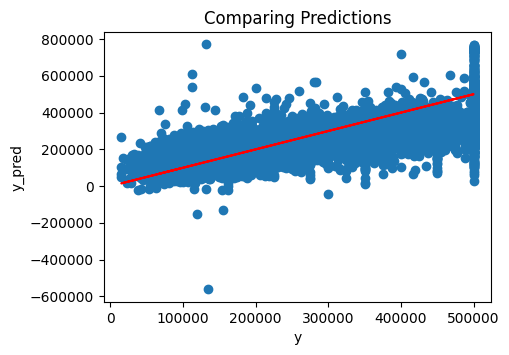

In [36]:
plt.figure(figsize=(5,3.5))

plt.scatter(y,model.predict(X))
plt.plot(y,y,color='r')

plt.xlabel('y')
plt.ylabel('y_pred')
plt.title('Comparing Predictions')

plt.show()

In [24]:
 df.median_house_value.mean()

207300.91235294117

In [30]:
from sklearn.tree import DecisionTreeRegressor

X = df.drop(columns='median_house_value')
y = df.median_house_value

model = DecisionTreeRegressor()
model.fit(X, y)

print("Score (R2): ", model.score(X, y)) # R2
print()

calculate_metrics(df.median_house_value, model.predict(X))
print()

# Predição
y_pred = model.predict(df_case)
print(f'Preço estimado (scikit-learn): {y_pred[0]:.2f}')

Score (R2):  1.0

MSE: 0.00
RMSE: 0.00
MAPE: 0.00
MAE: 0.00
sMAPE: 0.00
MAD: 91645.59

Preço estimado (scikit-learn): 174200.00


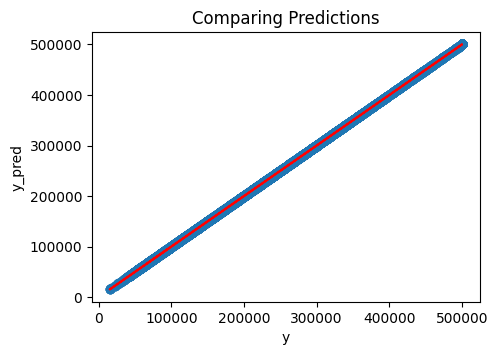

In [34]:
plt.figure(figsize=(5,3.5))

plt.scatter(y,model.predict(X))
plt.plot(y,y,color='r')

plt.xlabel('y')
plt.ylabel('y_pred')
plt.title('Comparing Predictions')

plt.show()